### Main objectives of notebook 

- Loading and exploring data 
- Checking for missing / presence of outliers 
- Generating basic visualisation plots

We import the necessary libraries; this requires the poetry environment to be set up, and set default plotting commands

In [1]:
import boto3
import warnings
import pandas as pd
import awswrangler as wr
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from src.config import PATHS, KEYS

style_sheet = PATHS.MISC_DIR / "base.mplstyle"
plt.style.use(style_sheet)

# display option to 30 columns and ignore warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 30)

%matplotlib inline

Connect to AWS Athena and query the data

In [2]:
TRAINING_QUERY = f"""
    SELECT
        *,
        case when uuid like '%_walk_%' then true else false end as target
    FROM
        "smu-iot"."microbit"
    WHERE
        seconds IS NOT null
      AND uuid IN ('clarence_walk_1', 'luna_ankle', 'luna_collar', 'sinhong_walk_1', 'songhan_bagstroll_1', 'licheng_situps_1', 'licheng_walk_1', 'licheng_dynamic_1', 'licheng_shaking_1', 'licheng_box_1', 'songhan_walk_1', 'songhan_walk_2', 'spencer_walk_1', 'licheng_walk_2')
    ORDER BY
        uuid, timestamp, seconds
"""

In [3]:
session = boto3.setup_default_session(
    region_name=KEYS.AWS_DEFAULT_REGION,
    aws_access_key_id=KEYS.AWS_ACCESS_KEY_ID,
    aws_secret_access_key=KEYS.AWS_SECRET_ACCESS_KEY,
)

step_counter_readings = wr.athena.read_sql_query(
    sql=TRAINING_QUERY,
    database="smu-iot"
)

What examples of activities are recorded? 

In [4]:
uuids = step_counter_readings["uuid"].unique()
pd.DataFrame(uuids, columns=["Unique UUIDs"])

,Unique UUIDs
0,luna_collar
1,sinhong_walk_1
2,songhan_bagstroll_1
3,songhan_walk_1
4,songhan_walk_2
5,spencer_walk_1
6,clarence_walk_1
7,licheng_box_1
8,licheng_dynamic_1
9,licheng_shaking_1


Are there missing values, if any?

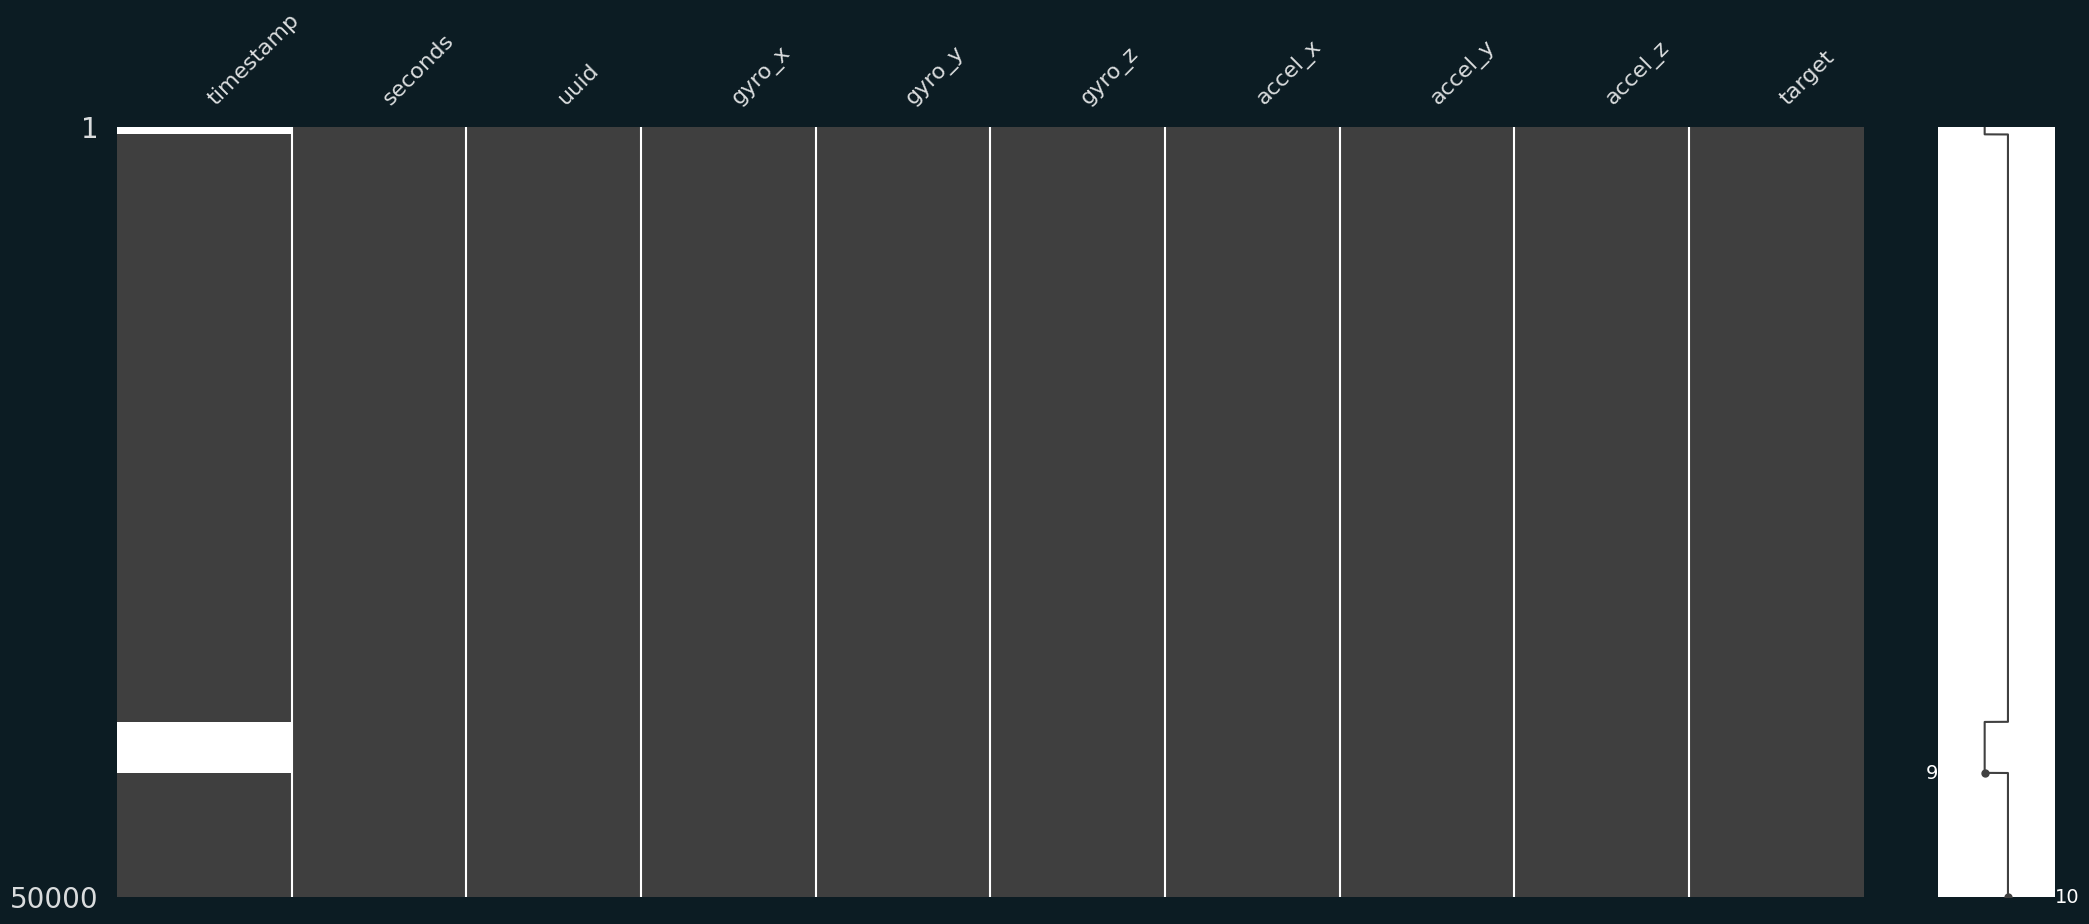

In [5]:
msno.matrix(step_counter_readings)
plt.show() 

Certain second intervals are null due to interference during the data collection phase. These observations will be removed in preprocessing

In [6]:
step_counter_readings.isna().sum()

timestamp    3800
seconds         0
uuid            0
gyro_x          0
gyro_y          0
gyro_z          0
accel_x         0
accel_y         0
accel_z         0
target          0
dtype: int64

Generate some summary statistics for the quantitative variables

In [7]:
quantitative_vars = ['gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y', 'accel_z']
cmap = sns.diverging_palette(0, 130, as_cmap=True)

mean_vals = (step_counter_readings[quantitative_vars]\
    .agg(["min", "max", "mean", "median"])\
    .transpose())

display(mean_vals.style.background_gradient(cmap, axis=0).format(precision=1))

,min,max,mean,median
gyro_x,-25.0,25.0,-0.4,0.0
gyro_y,-25.0,25.0,0.3,0.0
gyro_z,-25.0,25.0,0.0,0.0
accel_x,-204.0,204.0,-14.9,-23.0
accel_y,-204.0,204.0,54.6,76.0
accel_z,-204.0,204.0,-19.1,-23.0


What is the shape of our data overall? 
Most data is normally distributed with a median of 0

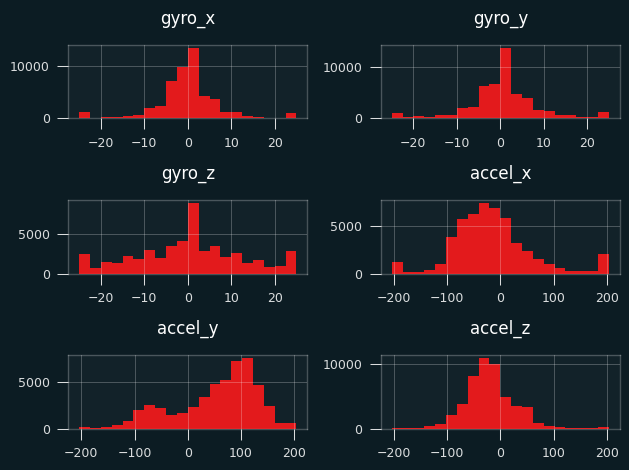

In [8]:
step_counter_readings[quantitative_vars].hist(bins=20)
plt.tight_layout() 
plt.show() 

A boxplot of the data shows that there is more variability in the data with the accelerometer readings

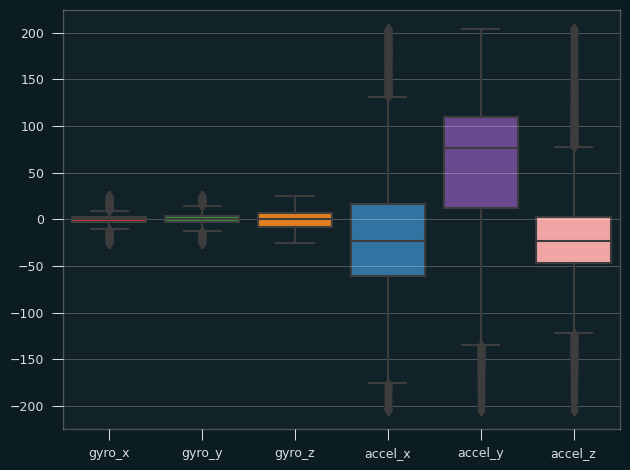

In [9]:
sns.boxplot(data=step_counter_readings[quantitative_vars])
plt.tight_layout()
plt.show() 

There are no obvious patterns in the scatter plot. This is expected as our data consists of a mix of different activities

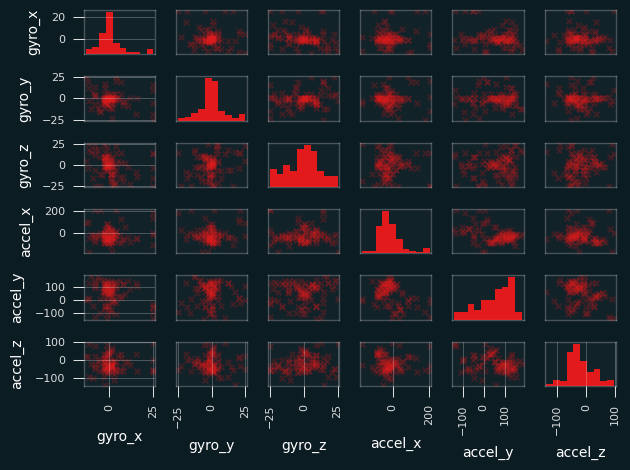

In [10]:
step_counter_sample = step_counter_readings.sample(100)
pd.plotting.scatter_matrix(step_counter_sample[quantitative_vars], marker="x", alpha=0.2)
plt.tight_layout() 
plt.show()